# Gravitational Wave Detection with Learnable Morlet Wavelets - Bank 14


This notebook trains a neural network with learnable Morlet wavelets for gravitational wave detection. 

The model combines matched filtering with learnable wavelet parameters and summary statistics for improved classification.## Load Data and Modules


In [ ]:
# Core libraries for deep learning and data processing
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import os
import torch
import time
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/home/apimpalkar/codes/training")
# Add path to custom training modules

In [ ]:
# Training configuration parameters
ib = 14          # Bank index for this training run
epochs = 40      # Maximum number of training epochs
patience = 15    # Early stopping patience (epochs without improvement)


In [ ]:
# Data loading utilities
from optimized_dataloader import create_dataloaders

# Data directory containing strain data and candidate statistics
data_dir = "/home/apimpalkar/codes/Data/without_score"

# GPU configuration - assign GPU based on bank index to distribute training
gpu_id = 1
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
print(f"Bank {ib} → Using device: {device}")

# Create PyTorch data loaders for training and validation
# Returns class weights for handling imbalanced datasets
train_loader, val_loader, weights = create_dataloaders(data_dir, ib)

Bank 14 → Using device: cpu


Number of coincident injections: 31686
Training samples: 38771
Validation samples: 12915
Training glitches: 14949, injections: 23822
Validation glitches: 5051, injections: 7864


# Model Architecture


The model consists of:

1. **LearnableMorlet**: Parameterized Morlet wavelets with trainable frequency and scale3. **FullModel**: Combines wavelet features with summary statistics for final classification
2. **MatchedFilterBank**: Bank of learnable wavelets for feature extraction  

In [ ]:
# Learnable Morlet wavelet with trainable scale parameter
# Uses log(scale) as parameter to prevent convergence to zero
class LearnableMorlet(nn.Module):
    def __init__(
        self,
        duration: float = 1.0,
        sample_rate: int = 256,
        frequency: float = 1.0,
        scale: float = 0.2,
    ):
        super().__init__()
        self.duration = duration
        self.sample_rate = sample_rate
        self.freq = frequency
        # Store log(scale) as the trainable parameter to prevent convergence to 0
        self.log_scale = nn.Parameter(torch.tensor(torch.log(torch.tensor(scale)), dtype=torch.float32))

    @property
    def scale(self):
        """Return the actual scale value (exp of log_scale)"""
        return torch.exp(self.log_scale)

    def forward(self, return_t: bool = False):
        # use the log_scale tensor's device
        dev = self.log_scale.device
        dt = 1.0 / self.sample_rate
        t = torch.arange(
            -self.duration / 2,
            self.duration / 2,
            step=dt,
            device=dev,
            dtype=torch.float32,
        )
        # Use the actual scale (exp of log_scale)
        actual_scale = self.scale
        gauss = torch.exp(-0.5 * (t / actual_scale) ** 2)
        sinusoid = torch.exp(1j * 2 * torch.pi * self.freq * t)
        wavelet = gauss * sinusoid

        # normalize
        norm = wavelet.norm(p=2)
        if norm > 0:
            wavelet = wavelet / norm

        return wavelet if not return_t else (wavelet, t)

In [ ]:
# Bank of learnable Morlet wavelets for matched filtering
# Processes left/right detector channels and extracts top-3 features per wavelet
class MatchedFilterBank(nn.Module):
    def __init__(self, wavelet_properties):
        super().__init__()
        self.wavelets = nn.ModuleList(
            [
                LearnableMorlet(
                    duration=wp["duration"],
                    sample_rate=wp.get("sample_rate", 256),
                    frequency=wp["frequency"],
                    scale=wp["scale"],
                )
                for wp in wavelet_properties
            ]
        )
        # 6 features per wavelet (3 values + 3 indices from combined left+right)
        self.features_per_wavelet = 6

    def forward(self, x_left, x_right):
        # x_left, x_right: (B, 1, T_in) each
        B = x_left.size(0)
        device = x_left.device
        all_feats = []

        for idx, wavelet in enumerate(self.wavelets):
            # generate complex kernel
            kernel = wavelet()  # shape (L,)
            real_k = kernel.real.view(1, 1, -1).to(device)
            imag_k = kernel.imag.view(1, 1, -1).to(device)

            # Process left and right channels
            combined_responses = []
            for x_channel in [x_left, x_right]:
                # convolution
                real_out = F.conv1d(x_channel, real_k, padding=0)  # (B,1,L_out)
                imag_out = F.conv1d(x_channel, imag_k, padding=0)  # (B,1,L_out)

                # phase correction
                phases = torch.atan2(imag_out, real_out)  # (B,1,L_out)
                real_r = real_out * torch.cos(phases) + imag_out * torch.sin(phases)
                
                combined_responses.append(real_r)
            
            # Combine left and right responses by taking element-wise max
            combined_response = torch.max(combined_responses[0], combined_responses[1])  # (B,1,L_out)
            
            # actual conv output length
            L_out = combined_response.size(2)

            # bucketed max + index → top-3 from combined response
            bucket_size = 26
            num_buckets = L_out // bucket_size
            rb = combined_response[..., : num_buckets * bucket_size].reshape(
                B, 1, num_buckets, bucket_size
            )  # (B,1,num_buckets,bucket_size)
            bucket_max, bucket_idx = rb.abs().max(dim=3)  # (B,1,num_buckets)
            top_vals, top_idxs = torch.topk(bucket_max, k=3, dim=2)  # (B,1,3)

            vals_flat = top_vals.view(B, -1)  # (B,3)
            idxs_norm = top_idxs.view(B, -1).float() / num_buckets  # (B,3)

            # concatenate features for this wavelet
            wavelet_feat = torch.cat([vals_flat, idxs_norm], dim=1)  # (B,6)
            all_feats.append(wavelet_feat)


        # final output: (B, num_wavelets * 6)        return torch.cat(all_feats, dim=1)

In [ ]:
# Complete model combining wavelet features with summary statistics
# Final MLP classifier for binary classification (signal vs. noise)
class FullModel(nn.Module):
    def __init__(self, wavelet_props, stats_dim=20):
        super().__init__()
        self.filterbank = MatchedFilterBank(wavelet_props)
        fb_dim = len(wavelet_props) * self.filterbank.features_per_wavelet
        self.classifier = nn.Sequential(
            nn.Linear(fb_dim + stats_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x_left, x_right, stats):
        # x_left, x_right: (B,1,T), stats: (B,stats_dim)
        f = self.filterbank(x_left, x_right)

        x = torch.cat([f, stats], dim=1)        return self.classifier(x)

In [ ]:
# Initialize wavelet bank with 6 different frequency channels
# Each wavelet targets different gravitational wave frequency ranges
wavelet_properties = [
    {"duration": 0.75, "frequency": 15, "scale": 0.05},
    {"duration": 0.75, "frequency": 20, "scale": 0.05},
    {"duration": 0.75, "frequency": 30, "scale": 0.05},
    {"duration": 0.75, "frequency": 40, "scale": 0.05},
    {"duration": 0.75, "frequency": 50, "scale": 0.05},

    {"duration": 0.75, "frequency": 60, "scale": 0.05},]

In [23]:
# Print wavelet properties for verification
print("Wavelet properties:")
for i, wp in enumerate(wavelet_properties):
    print(
        f"Wavelet {i}: Duration={wp['duration']:.4f}, Frequency={wp['frequency']}, Scale={wp['scale']:.4f}"
    )

Wavelet properties:
Wavelet 0: Duration=0.7500, Frequency=15, Scale=0.0500
Wavelet 1: Duration=0.7500, Frequency=20, Scale=0.0500
Wavelet 2: Duration=0.7500, Frequency=30, Scale=0.0500
Wavelet 3: Duration=0.7500, Frequency=40, Scale=0.0500
Wavelet 4: Duration=0.7500, Frequency=50, Scale=0.0500
Wavelet 5: Duration=0.7500, Frequency=60, Scale=0.0500


In [ ]:
# Initialize model with wavelet bank and 20-dimensional summary statistics
model = FullModel(wavelet_properties, stats_dim=20)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Set learning rate explicitly

model = model.to(device)

/tmp/ipykernel_1268283/1487171792.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_scale = nn.Parameter(torch.tensor(torch.log(torch.tensor(scale)), dtype=torch.float32))


In [25]:
model_path = f"/home/apimpalkar/codes/training/wavelets_models/{ib}_wavelet_model.pt"
best_val = float('inf')

In [ ]:
# Load pre-trained model if available, otherwise start from scratch
# Supports both new checkpoint format (with best_val_loss) and legacy format
try:
    model_path = f"/home/apimpalkar/codes/training/scoreless_models/{ib}_wavelet_model.pt"  # Replace with your .pt file path
    checkpoint = torch.load(model_path, map_location=device)

    if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
        # New-style checkpoint (dict with weights + best_val)
        model.load_state_dict(checkpoint["model_state_dict"])
        best_val = checkpoint.get("best_val_loss", float("inf"))
        print(f"Model loaded successfully. Best val loss was {best_val:.4f}")
    else:
        # Old-style checkpoint (just state_dict) wont be needed now 
        model.load_state_dict(checkpoint)
        best_val = float("inf")
        print("Model loaded successfully (old format, no best_val_loss saved).")

except FileNotFoundError:
    print(f"Model file '{model_path}' not found. Starting training from scratch.")
    best_val = float("inf")

model.to(device)
print("best_val initialized to:", best_val)

Model loaded successfully. Best val loss was 0.6210
best_val initialized to: 0.6209820823772063


# Model Training


Training loop with:

- Early stopping based on validation loss- Model checkpointing for best validation performance

- Learning rate scheduling with ReduceLROnPlateau  - NaN/Inf detection and batch skipping for stability

In [ ]:
# Utility function to detect NaN/Inf values during training
def check_for_nans(tensor, name):
    """Raise an error if tensor contains NaN or Inf."""
    if torch.isnan(tensor).any() or torch.isinf(tensor).any():
        raise ValueError(f"NaN/Inf detected in {name}! Aborting training.")


def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=10,
    save_path="best_model.pt",
    scheduler=None,
    best_val=float("inf"),
    early_stopping_patience=10,
    early_stopping_min_delta=1e-4
):

    # Initialize best_val (higher than any possible loss)
    best_val = best_val
    
    # Early stopping variables
    patience_counter = 0
    early_stop = False

    history = {
        "train_loss": [], "train_acc": [],
        "val_loss": [], "val_acc": [],
        "lr": []
    }

    if epochs <= 0:
        return model, history

    for epoch in range(1, epochs + 1):
        if early_stop:
            print(f"Early stopping triggered at epoch {epoch-1}")
            break
            
        print(f"Epoch {epoch}/{epochs}")
        start_time = time.time()

        # --- Training ---
        model.train()
        tloss = tcorrect = tcount = 0
        skipped_batches = 0

        for batch_idx, (X, X_stats, y) in enumerate(train_loader):
            # Move batch to device
            X, X_stats, y = X.to(device), X_stats.to(device), y.to(device)

            # Strict input checks
            check_for_nans(X, f"X (batch {batch_idx})")
            check_for_nans(X_stats, f"X_stats (batch {batch_idx})")
            check_for_nans(y, f"y (batch {batch_idx})")

            # Split into left/right
            Xl, Xr = X[:, 0, :].unsqueeze(1), X[:, 1, :].unsqueeze(1)

            if isinstance(criterion, torch.nn.CrossEntropyLoss):
                y_true = y.long()
            else:
                y_true = y.float().unsqueeze(1)

            optimizer.zero_grad()
            y_pred = model(Xl, Xr, X_stats)
            check_for_nans(y_pred, f"model outputs (batch {batch_idx})")

            if y_pred.shape != y_true.shape and not isinstance(criterion, torch.nn.CrossEntropyLoss):
                raise ValueError(f"Shape mismatch: y_pred {y_pred.shape}, y_true {y_true.shape}")

            loss = criterion(y_pred, y_true)
            check_for_nans(loss, f"loss (batch {batch_idx})")

            loss.backward()

            # Check gradients for NaN/Inf
            skip_batch = False
            for name, param in model.named_parameters():
                if param.grad is not None:
                    if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                        print(f"⚠️ NaN/Inf detected in grad of {name} (batch {batch_idx}) — skipping this batch.")
                        skip_batch = True
                        skipped_batches += 1
                        break

            if skip_batch:
                optimizer.zero_grad()
                continue

            optimizer.step()

            # Track loss and accuracy
            tloss += loss.item() * X.size(0)
            preds = (y_pred > 0.5).float() if not isinstance(criterion, torch.nn.CrossEntropyLoss) else y_pred.argmax(dim=1)
            tcorrect += (preds == y_true).sum().item()
            tcount += X.size(0)

        train_loss = tloss / max(tcount, 1)
        train_acc = tcorrect / max(tcount, 1)

        # --- Validation ---
        model.eval()
        vloss = vcorrect = vcount = 0
        with torch.no_grad():
            for batch_idx, (X, X_stats, y) in enumerate(val_loader):
                X, X_stats, y = X.to(device), X_stats.to(device), y.to(device)

                check_for_nans(X, f"Val X (batch {batch_idx})")
                check_for_nans(X_stats, f"Val X_stats (batch {batch_idx})")
                check_for_nans(y, f"Val y (batch {batch_idx})")

                Xl, Xr = X[:, 0, :].unsqueeze(1), X[:, 1, :].unsqueeze(1)
                y_true = y.long() if isinstance(criterion, torch.nn.CrossEntropyLoss) else y.float().unsqueeze(1)
                y_pred = model(Xl, Xr, X_stats)

                check_for_nans(y_pred, f"Val model outputs (batch {batch_idx})")
                loss = criterion(y_pred, y_true)
                check_for_nans(loss, f"Val loss (batch {batch_idx})")

                vloss += loss.item() * X.size(0)
                preds = (y_pred > 0.5).float() if not isinstance(criterion, torch.nn.CrossEntropyLoss) else y_pred.argmax(dim=1)
                vcorrect += (preds == y_true).sum().item()
                vcount += X.size(0)

        val_loss = vloss / max(vcount, 1)
        val_acc = vcorrect / max(vcount, 1)

        # 🔥 ReduceLROnPlateau update per epoch (after validation)
        if scheduler is not None:
            scheduler.step(val_loss)

        # Log LR (current learning rate)
        current_lr = optimizer.param_groups[0]['lr']
        mins, secs = divmod(time.time() - start_time, 60)

        print(f"         Train Loss = {train_loss:.4f}, Accuracy = {train_acc:.4f}")
        print(f"         Val Loss   = {val_loss:.4f}, Accuracy = {val_acc:.4f}")
        print(f"         LR         = {current_lr:.6f}")
        print(f"         Skipped batches this epoch: {skipped_batches}")
        print(f"         🕒 Epoch time: {int(mins)}:{int(secs):02d}")

        # Save best model and check early stopping
        if val_loss <= best_val - early_stopping_min_delta:
            best_val = val_loss
            patience_counter = 0  # Reset patience counter
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            checkpoint = {
                "model_state_dict": model.state_dict(),
                "best_val_loss": best_val
            }
            torch.save(checkpoint, save_path)
            print(f"         ✅ Best model saved at epoch {epoch} with val loss {best_val:.4f}")
        else:
            patience_counter += 1
            print(f"         No improvement. Patience: {patience_counter}/{early_stopping_patience}")
            
            if patience_counter >= early_stopping_patience:
                print(f"         🛑 Early stopping triggered! No improvement for {early_stopping_patience} epochs.")
                early_stop = True

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["lr"].append(current_lr)

    # --- After training ---
    if os.path.exists(save_path):
        checkpoint = torch.load(save_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        best_val = checkpoint["best_val_loss"]
        print(f"Loaded best model from disk with val loss {best_val:.4f}")
    else:
        print(f"⚠️ No saved model found at {save_path}, using final weights.")

    return model, history

In [ ]:
# Setup learning rate scheduler and run training
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',           # reduce LR when validation loss stops decreasing
    factor=0.5,           # reduce LR by this factor
    patience=3,           # wait this many epochs before reducing
    min_lr=1e-7,          # minimum learning rate
    threshold=1e-4,       # threshold for measuring improvement
    cooldown=1            # wait this many epochs after LR reduction before monitoring again
)

model, hist = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device=device,
    epochs=epochs,
    save_path=model_path,
    scheduler=scheduler,
    best_val=best_val,
    early_stopping_patience=patience,  # Stop if no improvement 
    early_stopping_min_delta=1e-4  # Minimum improvement threshold
)

Epoch 1/40


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 12730) — skipping this batch.


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 26190) — skipping this batch.


         Train Loss = 0.6236, Accuracy = 0.6380
         Val Loss   = 0.6245, Accuracy = 0.6160
         LR         = 0.000100
         Skipped batches this epoch: 2
         🕒 Epoch time: 11:15
         No improvement. Patience: 1/15
Epoch 2/40


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 16547) — skipping this batch.


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 33978) — skipping this batch.


         Train Loss = 0.6235, Accuracy = 0.6340
         Val Loss   = 0.6246, Accuracy = 0.6496
         LR         = 0.000100
         Skipped batches this epoch: 2
         🕒 Epoch time: 11:16
         No improvement. Patience: 2/15
Epoch 3/40


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 23854) — skipping this batch.


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 30885) — skipping this batch.


         Train Loss = 0.6230, Accuracy = 0.6359
         Val Loss   = 0.6244, Accuracy = 0.6513
         LR         = 0.000100
         Skipped batches this epoch: 2
         🕒 Epoch time: 11:25
         No improvement. Patience: 3/15
Epoch 4/40


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 1232) — skipping this batch.


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 2802) — skipping this batch.


         Train Loss = 0.6230, Accuracy = 0.6369
         Val Loss   = 0.6257, Accuracy = 0.6605
         LR         = 0.000100
         Skipped batches this epoch: 2
         🕒 Epoch time: 11:16
         No improvement. Patience: 4/15
Epoch 5/40


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 15528) — skipping this batch.


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 26255) — skipping this batch.


         Train Loss = 0.6226, Accuracy = 0.6378
         Val Loss   = 0.6227, Accuracy = 0.6121
         LR         = 0.000100
         Skipped batches this epoch: 2
         🕒 Epoch time: 11:10
         No improvement. Patience: 5/15
Epoch 6/40


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 14922) — skipping this batch.


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 26629) — skipping this batch.


         Train Loss = 0.6218, Accuracy = 0.6387
         Val Loss   = 0.6260, Accuracy = 0.5952
         LR         = 0.000100
         Skipped batches this epoch: 2
         🕒 Epoch time: 11:08
         No improvement. Patience: 6/15
Epoch 7/40


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 22986) — skipping this batch.


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 27753) — skipping this batch.


         Train Loss = 0.6223, Accuracy = 0.6356
         Val Loss   = 0.6225, Accuracy = 0.6428
         LR         = 0.000100
         Skipped batches this epoch: 2
         🕒 Epoch time: 11:05
         No improvement. Patience: 7/15
Epoch 8/40


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 2422) — skipping this batch.


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 9469) — skipping this batch.


         Train Loss = 0.6219, Accuracy = 0.6383
         Val Loss   = 0.6222, Accuracy = 0.6380
         LR         = 0.000100
         Skipped batches this epoch: 2
         🕒 Epoch time: 11:06
         No improvement. Patience: 8/15
Epoch 9/40


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 998) — skipping this batch.


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 6466) — skipping this batch.


         Train Loss = 0.6212, Accuracy = 0.6389
         Val Loss   = 0.6243, Accuracy = 0.6130
         LR         = 0.000100
         Skipped batches this epoch: 2
         🕒 Epoch time: 11:15
         No improvement. Patience: 9/15
Epoch 10/40


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 18288) — skipping this batch.


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 35685) — skipping this batch.


         Train Loss = 0.6212, Accuracy = 0.6376
         Val Loss   = 0.6251, Accuracy = 0.5863
         LR         = 0.000100
         Skipped batches this epoch: 2
         🕒 Epoch time: 11:30
         No improvement. Patience: 10/15
Epoch 11/40


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 15681) — skipping this batch.


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 15813) — skipping this batch.


         Train Loss = 0.6206, Accuracy = 0.6405
         Val Loss   = 0.6258, Accuracy = 0.6019
         LR         = 0.000100
         Skipped batches this epoch: 2
         🕒 Epoch time: 11:38
         No improvement. Patience: 11/15
Epoch 12/40


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 10311) — skipping this batch.


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 24732) — skipping this batch.


         Train Loss = 0.6208, Accuracy = 0.6397
         Val Loss   = 0.6240, Accuracy = 0.6441
         LR         = 0.000050
         Skipped batches this epoch: 2
         🕒 Epoch time: 11:28
         No improvement. Patience: 12/15
Epoch 13/40


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 5106) — skipping this batch.


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 15596) — skipping this batch.


         Train Loss = 0.6175, Accuracy = 0.6452
         Val Loss   = 0.6251, Accuracy = 0.6540
         LR         = 0.000050
         Skipped batches this epoch: 2
         🕒 Epoch time: 11:09
         No improvement. Patience: 13/15
Epoch 14/40


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 16553) — skipping this batch.


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 29205) — skipping this batch.


         Train Loss = 0.6174, Accuracy = 0.6461
         Val Loss   = 0.6232, Accuracy = 0.6100
         LR         = 0.000050
         Skipped batches this epoch: 2
         🕒 Epoch time: 11:12
         No improvement. Patience: 14/15
Epoch 15/40


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 23563) — skipping this batch.


⚠️ NaN/Inf detected in grad of filterbank.wavelets.0.log_scale (batch 28567) — skipping this batch.


         Train Loss = 0.6171, Accuracy = 0.6459
         Val Loss   = 0.6226, Accuracy = 0.6403
         LR         = 0.000050
         Skipped batches this epoch: 2
         🕒 Epoch time: 11:10
         No improvement. Patience: 15/15
         🛑 Early stopping triggered! No improvement for 15 epochs.
Early stopping triggered at epoch 15
Loaded best model from disk with val loss 0.6210


# Model Evaluation and Analysis


Evaluation includes:

- Validation set predictions and probability distributions- Bayesian calibration for probability scores

- Learned wavelet visualization- Spectrogram analysis with wavelet responses

In [ ]:


def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label="Train Loss", marker="o")
    plt.plot(epochs, val_losses, label="Validation Loss", marker="x")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# plot_losses(hist["train_loss"], hist["val_loss"])

In [ ]:
import numpy as np
import torch

# Generate predictions on validation set for analysis
# Applies probability scaling and returns predictions with true labels
def get_val_predictions(model, val_loader, device=device):
    model.to(device)
    model.eval()

    preds, labels = [], []
    with torch.no_grad():
        for X, X_stats, y in val_loader:
            X = X.to(device)            # (B, 2, 3712)
            X_stats = X_stats.to(device)
            y_true = y.to(device)

            # Split into left/right
            Xl, Xr = X[:, 0, :].unsqueeze(1), X[:, 1, :].unsqueeze(1)  # ✅ shape (B,1,T)

            # Forward pass → logits
            logits = model(Xl, Xr, X_stats)

            # Convert logits → probabilities
            probs = torch.sigmoid(logits).squeeze(1)
            # If you want to scale all probabilities < 0.85 by 1/0.85, else set to 1
            probs = torch.where(probs < 0.85, probs / 0.85, torch.ones_like(probs))
            preds.append(probs.cpu())
            labels.append(y_true.cpu())

    preds = torch.cat(preds, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    return preds, labels



def calibrate_bayesian(p_raw, y_true, n_bins=30, epsilon=0.05):
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    signal_hist, _ = np.histogram(p_raw[y_true == 1], bins=bin_edges)
    noise_hist, _ = np.histogram(p_raw[y_true == 0], bins=bin_edges)

    def density_sum(x, hist):
        idxs = np.abs(bin_centers - x) <= epsilon
        return np.sum(hist[idxs]) / len(p_raw)  # normalize to total count

    calibrated_probs = []
    for x in p_raw:
        n_sig = density_sum(x, signal_hist)
        n_noise = density_sum(x, noise_hist)
        p_bayes = n_sig / (n_sig + n_noise + 1e-10)
        calibrated_probs.append(p_bayes)

    return np.array(calibrated_probs)


# === Example usage ===
raw_preds, labels = get_val_predictions(model, val_loader, device)


# Split for plotting
glitch_preds_raw = raw_preds[labels == 0]
injection_preds_raw = raw_preds[labels == 1]



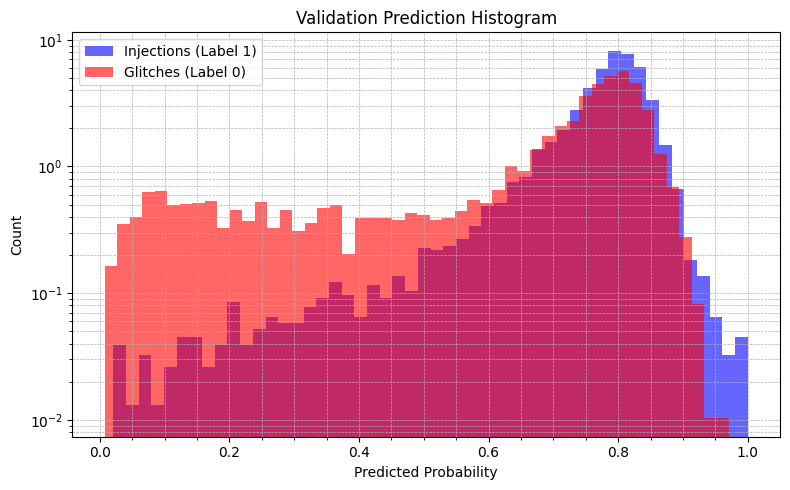

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(
    injection_preds_raw,
    bins=50,
    alpha=0.6,
    label="Injections (Label 1)",
    color="blue",
    log=True,
    density=True,
)
plt.hist(
    glitch_preds_raw,
    bins=50,
    alpha=0.6,
    label="Glitches (Label 0)",
    color="red",
    log=True,
    density=True,
)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Validation Prediction Histogram")
plt.legend()
plt.grid(True, which="both", axis="both", linestyle="--", linewidth=0.5)
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
import matplotlib as mpl
plt.rcParams["figure.figsize"] = (5, 3)
plt.rcParams["axes.grid"]=True;plt.rcParams["grid.alpha"]=0.4; 
plt.rcParams["grid.color"]='#999999'; plt.rcParams["grid.linestyle"]='--'
def mpl_settings(settings):
    if (settings=='default'):
        mpl.rc('text', usetex=False)
        mpl.rcParams['legend.fontsize'] = 'medium'
        plt.rcParams["xtick.labelsize"] = 'medium'
        plt.rcParams["ytick.labelsize"] = 'medium'
        plt.rcParams['axes.labelsize'] = 'medium' 
        plt.rcParams["figure.figsize"] = [5.0, 3.0]
    elif(settings=='paper'):
        mpl.rc('text', usetex=True)
        plt.rcParams["xtick.labelsize"] = 13; plt.rcParams["ytick.labelsize"] = 13
        plt.rcParams['axes.labelsize']=16
mpl_settings('paper')

Wavelet 0 L2 norm: 1.0
Wavelet 1 L2 norm: 1.0
Wavelet 2 L2 norm: 0.99999994
Wavelet 3 L2 norm: 0.99999994
Wavelet 4 L2 norm: 1.0
Wavelet 5 L2 norm: 1.0


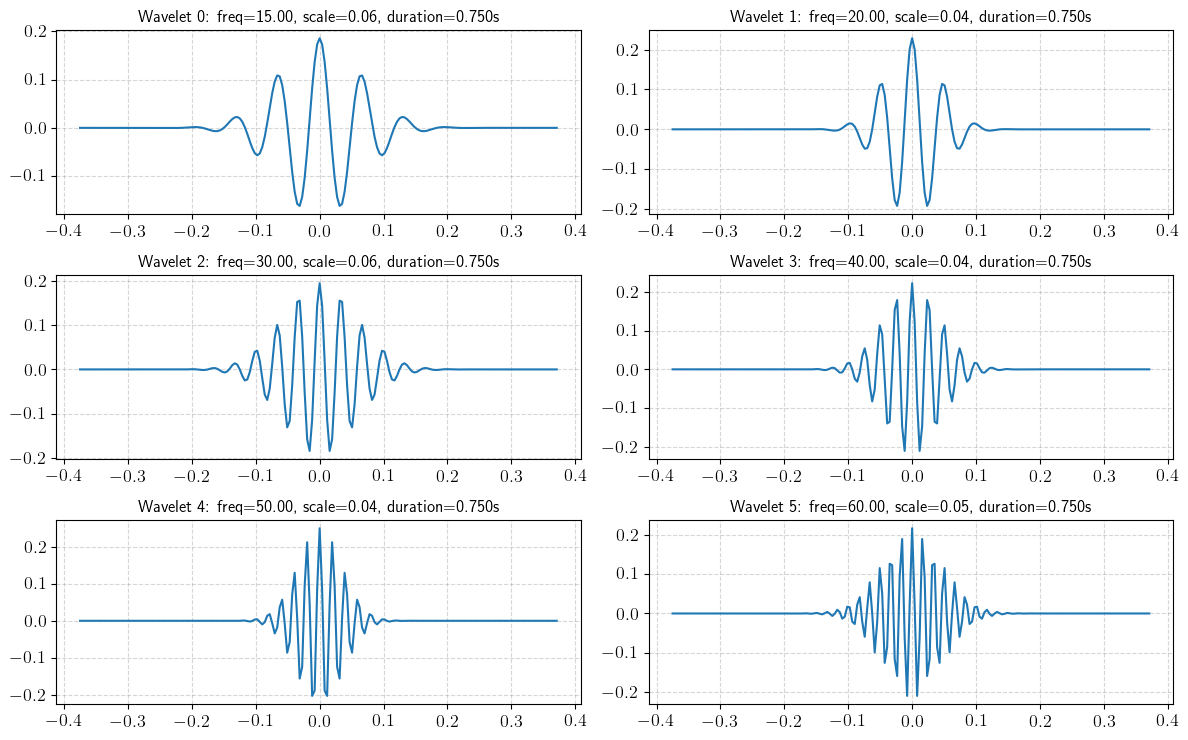

In [ ]:
# Visualize the learned Morlet wavelets after training
# Shows how wavelet parameters (frequency, scale, duration) evolved during training
def plot_learned_wavelets(model):
    n = len(model.filterbank.wavelets)
    cols = 2
    rows = (n + cols - 1) // cols  # Calculate rows needed
    
    fig, axs = plt.subplots(rows, cols, figsize=(12, 2.5 * rows))
    
    # Handle case where we have only one row
    if rows == 1:
        axs = axs.reshape(1, -1)
    elif n == 1:
        axs = axs.reshape(-1)

    for i, wavelet in enumerate(model.filterbank.wavelets):
        row = i // cols
        col = i % cols
        
        with torch.no_grad():
            w, t = wavelet(return_t=True)
            freq = float(wavelet.freq)
            scale = float(wavelet.scale)  # Direct access to the scale parameter
            duration = float(wavelet.duration)

            w_np = w.cpu().numpy()
            
            if rows == 1:
                ax = axs[col]
            else:
                ax = axs[row, col]
                
            ax.plot(t.cpu().numpy(), w_np.real, label="Real")
            # ax.plot(t.cpu().numpy(), w_np.imag, label="Imag", linestyle="--")
            ax.set_title(f"Wavelet {i}: freq={freq:.2f}, scale={scale:.2f}, duration={duration:.3f}s")
            # ax.legend()

            print(f"Wavelet {i} L2 norm:", np.linalg.norm(w_np))

    # Hide empty subplots if n is odd
    if n % cols != 0:
        for i in range(n, rows * cols):
            row = i // cols
            col = i % cols
            if rows == 1:
                axs[col].set_visible(False)
            else:
                axs[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(f"/home/apimpalkar/codes/plots/learned_wavelets_bank_{ib}.pdf")
    plt.show()

plot_learned_wavelets(model)

In [ ]:
# Analyze single data sample with spectrograms and wavelet filter responses
# Shows how each learned wavelet responds to the input strain data
def plot_spectrogram_and_wavelet_snr_sample(left, right, model=model):
    """
    Inputs:
      - left: 1D or 2D torch tensor of shape (T,) or (1, T)
      - right: 1D or 2D torch tensor of shape (T,) or (1, T)
      - model: trained model (with complex-valued wavelets)

    Shows:
      - Spectrograms of both sides
      - Wavelet SNR responses (magnitude of matched filter conv) from filter bank
    """
    if left.ndim == 2 and left.shape[0] == 1:
        left = left.squeeze(0)
    if right.ndim == 2 and right.shape[0] == 1:
        right = right.squeeze(0)

    left_np = left.detach().cpu().numpy()
    right_np = right.detach().cpu().numpy()

    # Plot spectrograms
    Fs = 256
    NFFT = 64
    noverlap = 32

    fig, axs = plt.subplots(1, 2, figsize=(20, 4), sharey=True)
    axs[0].specgram(left_np, NFFT=NFFT, Fs=Fs, noverlap=noverlap, scale="linear")
    axs[0].set_title("Spectrogram - Left")
    axs[1].specgram(right_np, NFFT=NFFT, Fs=Fs, noverlap=noverlap, scale="linear")
    axs[1].set_title("Spectrogram - Right")
    plt.tight_layout()
    plt.show()

    # Prepare input for model (1, 2, T)
    x = (
        torch.stack([left, right], dim=0)
        .unsqueeze(0)
        .to(next(model.parameters()).device)
    )

    num_wavelets = len(model.filterbank.wavelets)
    fig, axs = plt.subplots(
        num_wavelets, 2, figsize=(14, 3 * num_wavelets), sharex=True
    )

    if num_wavelets == 1:
        axs = np.expand_dims(axs, axis=0)

    for i, wavelet in enumerate(model.filterbank.wavelets):
        with torch.no_grad():
            kernel = wavelet()  # complex-valued (L,)
            kernel_real = kernel.real.view(1, 1, -1).to(x.device)
            kernel_imag = kernel.imag.view(1, 1, -1).to(x.device)
            pad = 0

            # Real and imaginary convs separately
            real_left = F.conv1d(x[:, 0:1, :], kernel_real, padding=pad)
            imag_left = F.conv1d(x[:, 0:1, :], kernel_imag, padding=pad)
            snr_left = torch.sqrt(real_left**2 + imag_left**2).squeeze().cpu().numpy()

            real_right = F.conv1d(x[:, 1:2, :], kernel_real, padding=pad)
            imag_right = F.conv1d(x[:, 1:2, :], kernel_imag, padding=pad)
            snr_right = (
                torch.sqrt(real_right**2 + imag_right**2).squeeze().cpu().numpy()
            )

        # Safe conversions
        freq = float(wavelet.freq)
        scale = float(wavelet.scale)  # Direct access to scale parameter
        duration = float(wavelet.duration)

        axs[i, 0].plot(snr_left)
        axs[i, 0].set_title(
            f"Wavelet {i} Left (freq={freq:.2f}, scale={scale:.2f}, dur={duration:.3f}s)"
        )
        axs[i, 0].set_ylabel("SNR")

        axs[i, 1].plot(snr_right)
        axs[i, 1].set_title(
            f"Wavelet {i} Right (freq={freq:.2f}, scale={scale:.2f}, duration={duration:.3f}s)"
        )

    axs[-1, 0].set_xlabel("Time")
    axs[-1, 1].set_xlabel("Time")

    plt.tight_layout()    plt.show()

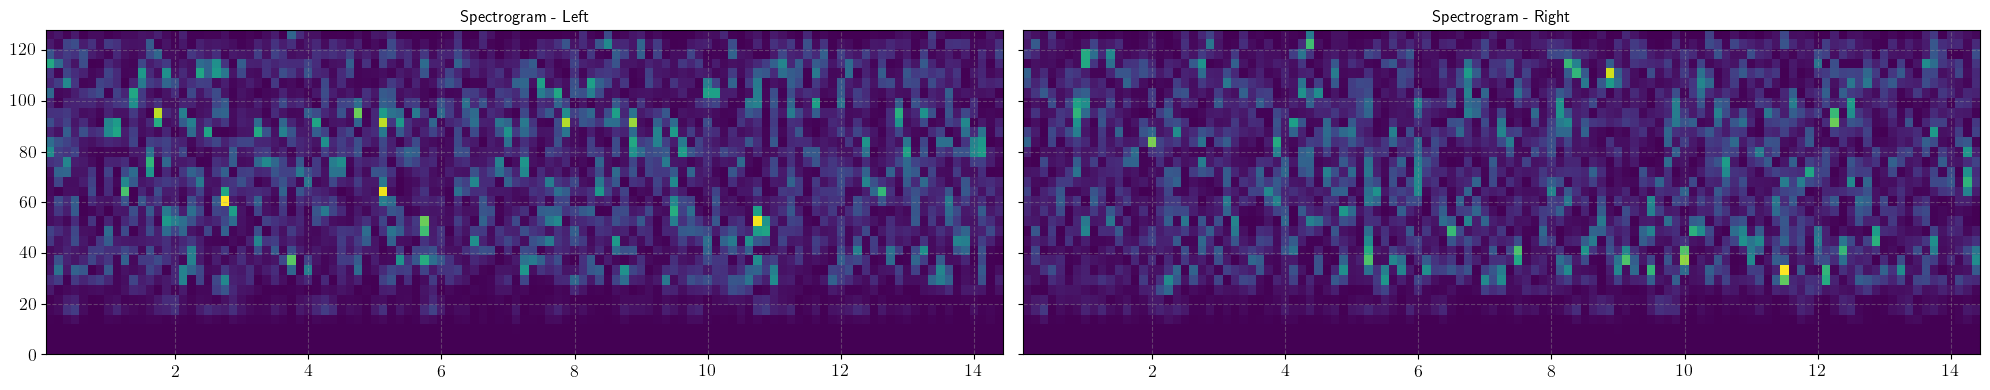

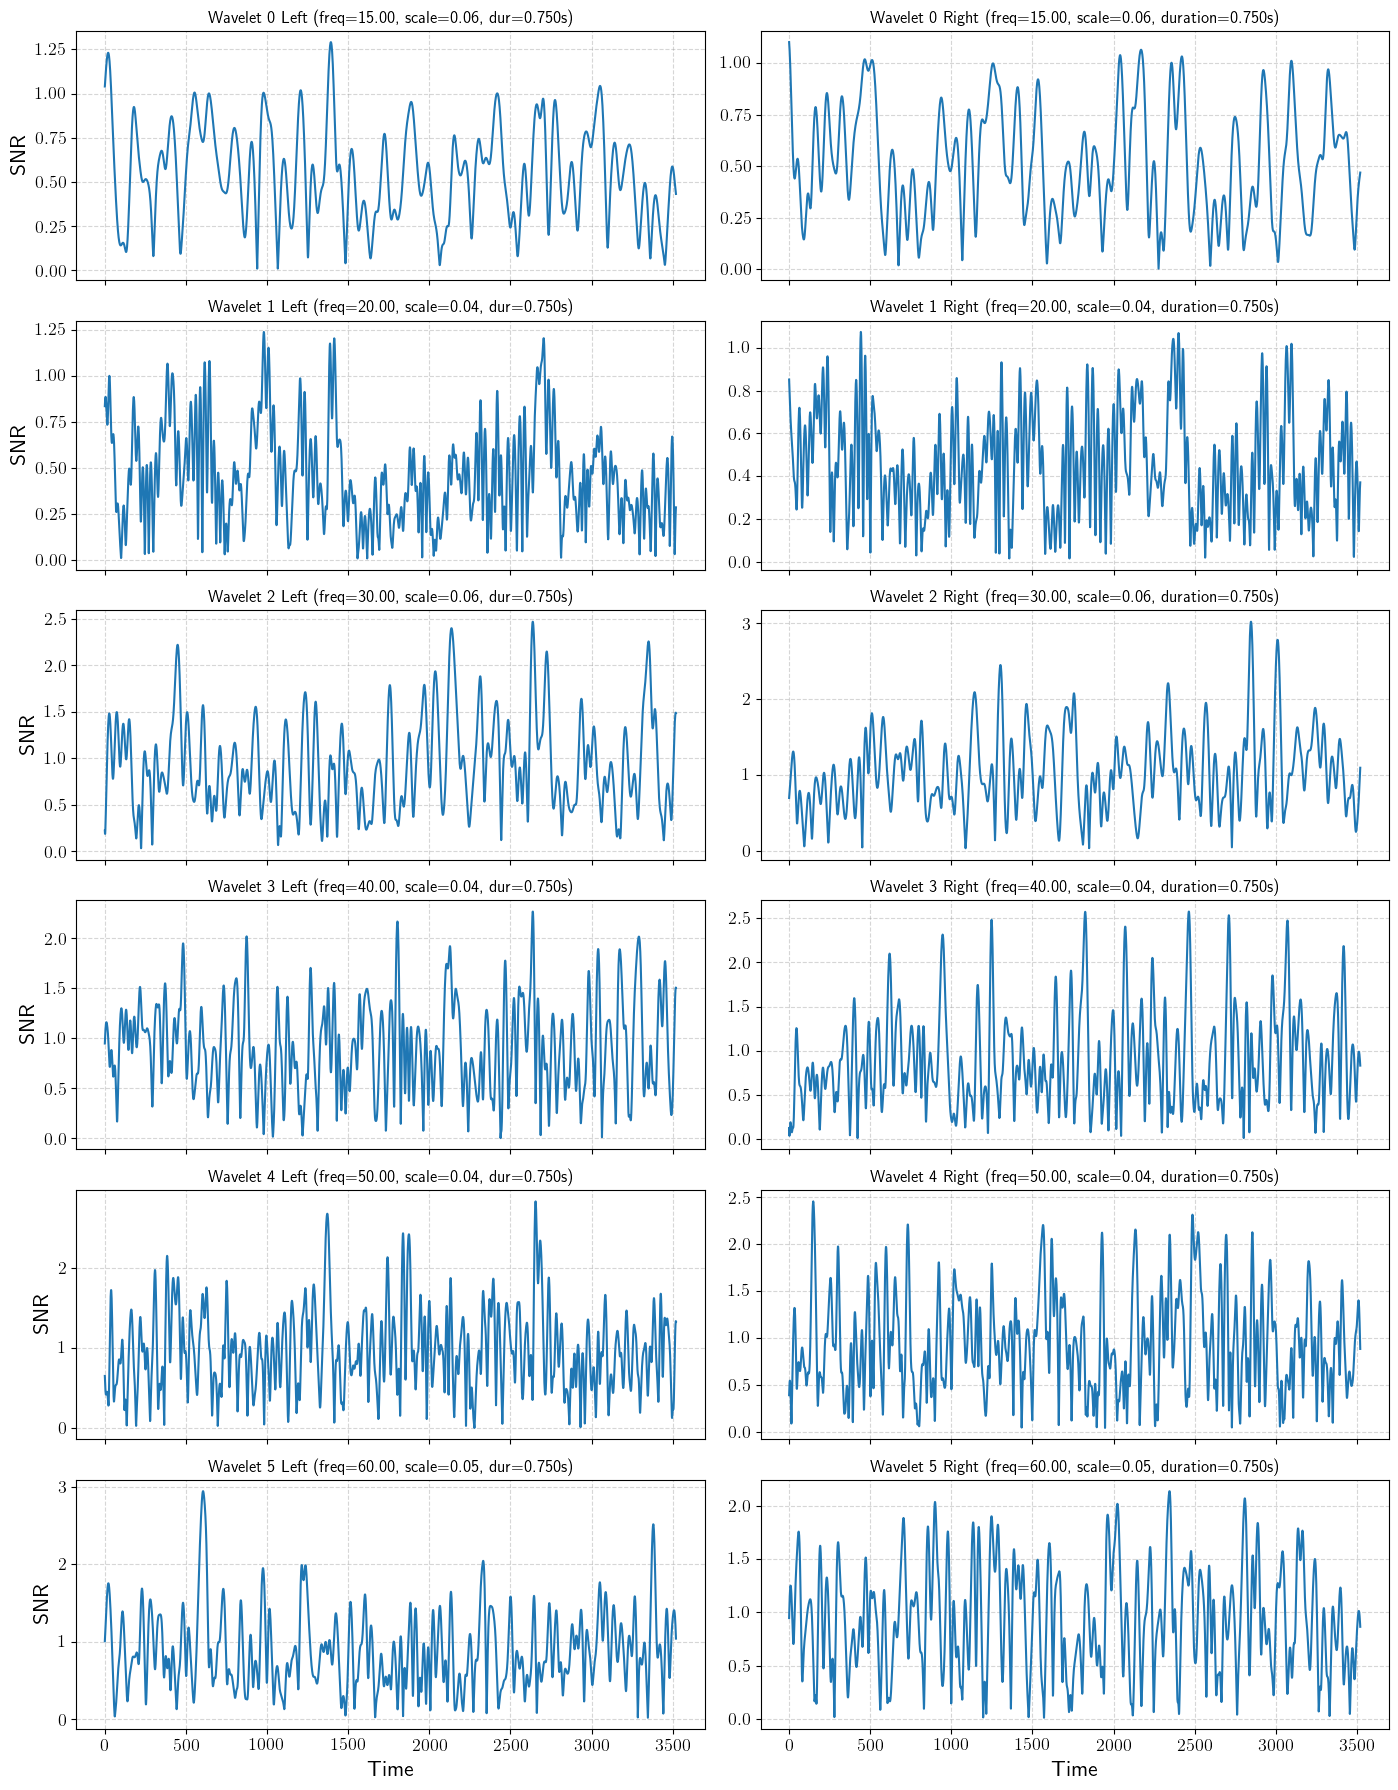

In [ ]:
i = 1252  # Change this index to visualize different samples

(X_left, X_right), X_stats_i, y_i = train_loader.dataset[i]

plot_spectrogram_and_wavelet_snr_sample(X_left, X_right)

# IFAR (Inverse False Alarm Rate) Analysis



Calculate detection statistics and compare with baseline ranking:4. Compare new vs. old IFAR values to assess improvement

1. Load injection and candidate data3. Calibrate ranking statistics using Bayesian approach
2. Generate model predictions for all candidate classes  

In [ ]:
# Load strain data, candidates, and ranking objects for IFAR analysis
import pickle
import numpy as np

with open(data_dir + f"/Extended_Strain_{ib}.pkl", "rb") as f:
    extended_strain_dets = pickle.load(f)
with open(data_dir + f"/Cands_bank_{ib}.pkl", "rb") as f:
    sum_stats_dets = pickle.load(f)
with open(data_dir + f"/inds_sorted_{ib}.pkl", "rb") as f:
    inds_sorted = pickle.load(f)
with open(data_dir + f"/Times_cands_{ib}.pkl", "rb") as f:
    times_cands_dets = pickle.load(f)

In [ ]:
# Process coincident injections that appear in both detectors
# Apply quality cuts: distance from data holes > 1 sec, PSD drift > 0.5
coincident_injs = []
total_rank_obj_cands = len(np.concatenate(inds_sorted))
for i in range(len(sum_stats_dets[0])):
    if sum_stats_dets[0][i] is not None and sum_stats_dets[1][i] is not None:
        if i < total_rank_obj_cands:
            coincident_injs.append(i)
        # Also keeping only the extra injs with dist from hole > 1 sec and PSD drift >0.5
        # as these are also the selection criteria for triggers in the pipeline
        elif np.all(
            np.array([sum_stats_dets[0][i][1], sum_stats_dets[1][i][1]]) > 0
        ) and np.all(
            np.array([sum_stats_dets[0][i][3], sum_stats_dets[1][i][3]]) > 0.5
        ):
            coincident_injs.append(i)
    elif i < total_rank_obj_cands:
        print(i)
        raise RuntimeError("Why is one of the rank_obj_cands None?")
        # This can happen only under very very exceptional cases
inds_sorted.append(
    np.array(coincident_injs[total_rank_obj_cands:]) - total_rank_obj_cands

)print(f"Number of coincident injections: {len(coincident_injs[total_rank_obj_cands:])}")

Number of coincident injections: 31686


In [29]:
sum_stats_dets = [[sum_stats_dets[j][i] for i in coincident_injs] for j in range(2)]

In [30]:
for i in range(1000):
    if sum_stats_dets[0][i][4] is not None:
        triglist_dim = sum_stats_dets[0][i][4].shape[-1]
        break
print("triglist_dim is", triglist_dim)

triglist_dim is 5


In [31]:
def triglist_pad_fn(triglist, length=3, triglist_dim=4):
    triglist_pad = []
    n_elements = []
    for t in triglist:
        if t is not None:
            n_elements.append(len(t))
            t = t[np.argsort(t[:, 1])[::-1][:length]]
            if len(t) < length:
                t = np.r_[t, np.zeros((length - len(t), triglist_dim))]
            triglist_pad.append(t)
        else:
            n_elements.append(0)
            triglist_pad.append(np.zeros((length, triglist_dim)))
    return (np.array(n_elements), np.array(triglist_pad))

In [32]:
be_mask = []
t_closest_hole = []
normfac = []
pdrift = []
n_trig = []
triglist_H = []
triglist_L = []
triglist_pad = []
pad_length = 3
i = 0  # index for sum_stats within sum_stats_dets
for i_cand in range(6):
    be_mask_cand = []
    t_closest_hole_cand = []
    normfac_cand = []
    pdrift_cand = []
    triglist_H_cand = []
    triglist_L_cand = []
    if len(inds_sorted[i_cand]) > 0:
        for ind in range(len(inds_sorted[i_cand])):
            be_mask_cand.append([sum_stats_dets[0][i][0], sum_stats_dets[1][i][0]])
            t_closest_hole_cand.append(
                [sum_stats_dets[0][i][1], sum_stats_dets[1][i][1]]
            )
            normfac_cand.append([sum_stats_dets[0][i][2], sum_stats_dets[1][i][2]])
            pdrift_cand.append([sum_stats_dets[0][i][3], sum_stats_dets[1][i][3]])
            triglist_H_cand.append(sum_stats_dets[0][i][4])
            triglist_L_cand.append(sum_stats_dets[1][i][4])
            i += 1
        be_mask_cand = np.array(be_mask_cand)
        t_closest_hole_cand = np.array(t_closest_hole_cand)
        if np.count_nonzero(t_closest_hole_cand <= -1) > 0:
            print(
                f"For icand {i_cand}: found {np.count_nonzero(t_closest_hole_cand<=-1)} entries with t_closest_hole <= -1"
            )
            t_closest_hole_cand[t_closest_hole_cand <= -1] = -1
        normfac_cand = np.array(normfac_cand)
        pdrift_cand = np.array(pdrift_cand)
        if np.count_nonzero(pdrift_cand <= 0.4) > 0:
            print(
                f"For icand {i_cand}: found {np.count_nonzero(pdrift_cand<=0.4)} entries with pdrift <= 0.4"
            )
            pdrift_cand[pdrift_cand <= 0.4] = 0.4
        n_trig_cand = np.zeros((2, len(be_mask_cand)))
        triglist_cand = np.zeros((2, len(be_mask_cand), pad_length, triglist_dim))
        n_trig_cand[0], triglist_cand[0] = triglist_pad_fn(
            triglist_H_cand, pad_length, triglist_dim
        )
        n_trig_cand[1], triglist_cand[1] = triglist_pad_fn(
            triglist_L_cand, pad_length, triglist_dim
        )
    else:
        n_trig_cand = []
        triglist_cand = []
    be_mask.append(be_mask_cand)
    t_closest_hole.append(t_closest_hole_cand)
    normfac.append(normfac_cand)
    pdrift.append(pdrift_cand)
    n_trig.append(n_trig_cand)
    triglist_H.append(triglist_H_cand)
    triglist_L.append(triglist_L_cand)
    triglist_pad.append(triglist_cand)

For icand 0: found 85 entries with t_closest_hole <= -1


In [33]:
inputs_cands_dets = []
inputs_injs_dets = []
for ind_det in range(2):
    inputs_cands = []
    for cand_type in range(6):
        if len(be_mask[cand_type]) == 0:
            inputs_cand = []
        else:
            inputs_cand = np.c_[
                be_mask[cand_type][:, ind_det].astype(float),
                t_closest_hole[cand_type][:, ind_det].astype(float),
                normfac[cand_type][:, ind_det].astype(float),
                pdrift[cand_type][:, ind_det].astype(float),
                n_trig[cand_type][ind_det].astype(float),
                triglist_pad[cand_type][ind_det, :, :, :]
                .astype(float)
                .reshape(-1, pad_length * triglist_dim),
            ]
        inputs_cands.append(inputs_cand)
    inputs_cands_dets.append(inputs_cands)

In [34]:

extended_strain_dets = [
    [extended_strain_dets[j][i] for i in coincident_injs] for j in range(2)
]

# %%
strain_classes = []
i = 0  # index within extended_strain_dets
for i_class in range(len(inds_sorted)):
    strain_class = []
    if len(inds_sorted[i_class]) > 0:
        for ind in range(len(inds_sorted[i_class])):
            strain_class.append(
                [extended_strain_dets[0][i][0], extended_strain_dets[1][i][0]]
            )
            i += 1
        strain_class = np.array(strain_class)
    else:
        strain_class = []
    strain_classes.append(strain_class)

gap = 0.5
Fs = 256
# Helper: Process one time series and split with a gap
def process_single_timeseries(x):
    data_length = len(x)
    center = data_length // 2
    gap_size = int(gap * Fs)
    start_index = center - gap_size
    end_index = center + gap_size

    left_x = x[:start_index]
    right_x = x[end_index:]

    return left_x, right_x

left , right = process_single_timeseries(strain_classes[0][0][1])


In [35]:
len(strain_classes[0]), len(strain_classes[1]), len(strain_classes[2]), len(strain_classes[3]), len(strain_classes[4]), len(strain_classes[5])

(20000, 66, 0, 3367, 208, 31686)

In [36]:
left_injections_data = []
right_injections_data = []

for i in (0, 1, 2, 3, 4, 5):
    data_left = []
    data_right = []
    for j in range(len(strain_classes[i])):
        left_x, right_x = process_single_timeseries(strain_classes[i][j][1])
        data_left.append(left_x)
        data_right.append(right_x)
    left_injections_data.append(np.array(data_left))
    right_injections_data.append(np.array(data_right))


In [ ]:
# Generate model predictions for ranking analysis with batch processing
# Applies probability scaling below threshold for calibration
def get_model_predictions_for_ranking(model, X_left_data, X_right_data, X_stats_data, device='cpu', scale_threshold=0.85):
    """
    Generate model predictions for ranking analysis
    """
    model.eval()
    model.to(device)
    predictions = []
    
    batch_size = 64  # Process in batches to avoid memory issues
    num_samples = len(X_left_data)
    
    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            end_idx = min(i + batch_size, num_samples)
            
            # Prepare batch
            batch_left = torch.tensor(X_left_data[i:end_idx], dtype=torch.float32).to(device)
            batch_right = torch.tensor(X_right_data[i:end_idx], dtype=torch.float32).to(device)
            batch_stats = torch.tensor(X_stats_data[i:end_idx], dtype=torch.float32).to(device)
            
            # Add channel dimension for left and right
            batch_left = batch_left.unsqueeze(1)  # (B, 1, T)
            batch_right = batch_right.unsqueeze(1)  # (B, 1, T)
            
            # Get logits from model and apply sigmoid to get probabilities
            logits = model(batch_left, batch_right, batch_stats).squeeze()
            probs = torch.sigmoid(logits).cpu().numpy()
            # Convert probs to tensor for torch operations
            probs_tensor = torch.from_numpy(probs)
            probs_tensor = torch.where(probs_tensor < scale_threshold, probs_tensor / scale_threshold, torch.ones_like(probs_tensor))
            probs = probs_tensor.numpy()
            if probs.ndim == 0:  # Single sample case
                probs = [probs]
            predictions.extend(probs)

        return np.array(predictions)

In [38]:
all_scores = []

for i in range(6): 
    pred = get_model_predictions_for_ranking(
            model,
            left_injections_data[i],   
            right_injections_data[i],
            inputs_cands_dets[0][i],
            device
        )
    all_scores.append(pred)

In [39]:
len(all_scores[0]), len(all_scores[1]), len(all_scores[2]), len(all_scores[3]), len(all_scores[4]), len(all_scores[5])

(20000, 66, 0, 3367, 208, 31686)

In [40]:
from sklearn.isotonic import IsotonicRegression
from scipy.interpolate import PchipInterpolator

In [41]:
probs_cands_dets = []
probs_cands_dets.append(all_scores)
# probs_cands_dets.append(all_scores) # just to mimic L1 detector

In [ ]:
# Calculate ranking statistics using background and injection histograms
# Apply isotonic regression for monotonic ranking function
rank_surrounding_dets = []
old_score_dets = []
score_dets = []
bincent_dets = []
num_bins = 15

for i_det in range(1):
    probs_cands = probs_cands_dets[i_det]
    weights_bg = 1/(np.arange(len(probs_cands[0]))+1)
    val_bg, bins = np.histogram(probs_cands[0], bins=num_bins, weights=weights_bg/np.sum(weights_bg))
    val_inj = np.histogram(probs_cands[-1], bins=bins, weights=np.ones(len(probs_cands[-1]))/len(probs_cands[-1]))[0]
    min_valid_ind = np.amin(np.where(val_inj>0)[0])
    val_inj = val_inj[min_valid_ind:]
    val_bg = val_bg[min_valid_ind:]
    val_inj += np.amin(val_inj[val_inj>0])
    score = 2*np.log(val_inj/val_bg)
    mask = ~np.isinf(score) * ~np.isnan(score)
    bincent = 0.5*(bins[1:]+bins[:-1])[min_valid_ind:]
    bincent = bincent[mask]
    score = score[mask]
    old_score_dets.append(score)
    bincent_dets.append(bincent)
    iso_reg = IsotonicRegression(increasing=True)
    score = iso_reg.fit_transform(bincent, score) 
    score_dets.append(score)

    rank_surrounding_dets.append(PchipInterpolator(np.r_[0, bincent, 1],                                                    np.r_[score[0],score, score[-1]], extrapolate=True))

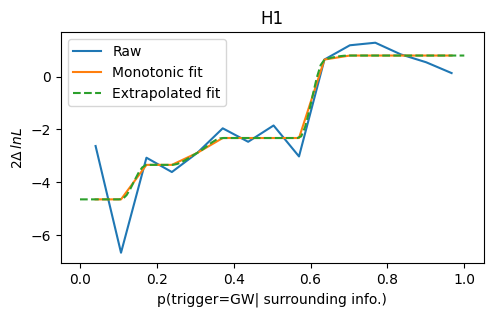

In [43]:
plt.figure(figsize=(12,3))
detectors = ['H1', 'L1']
for i_det in range(1):
    plt.subplot(1,2,i_det+1)
    plt.plot(bincent_dets[i_det], old_score_dets[i_det], label='Raw')
    plt.plot(bincent_dets[i_det], score_dets[i_det], label='Monotonic fit')
    plt.plot(np.linspace(0,1,100),rank_surrounding_dets[i_det](np.linspace(0,1,100)), ls='--', label='Extrapolated fit')
    plt.xlabel('p(trigger=GW| surrounding info.)'); plt.ylabel(r'$2\Delta\, lnL$')
    plt.title(detectors[i_det]) 
    if i_det==0:
        plt.legend() 

In [44]:
sys.path.append("/home/apimpalkar/codes/gw_detection_ias")

import ranking_HM as rank
run = 'O3b'
two_inj_sets=True

/home/apimpalkar/codes/gw_detection_ias/coherent_score_mz_fast.py:24: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [45]:
rank_obj_dir_IMBH = f'/data/jayw/IAS/GW/Data/HM_{run}_search/Ranking/With_Injections/LVK_IMBH'
rank_obj_dir_BBH = f'/data/jayw/IAS/GW/Data/HM_{run}_search/Ranking/With_Injections/LVK_BBH'


In [46]:
# Loading the rank object for the bank
rank_obj = rank.Rank.from_hdf5(os.path.join(rank_obj_dir_IMBH, f"BBH_{ib}.hdf5"), mode='r')

Couldn't access / properly, falling back to base group


In [47]:
# Detection statistic scores for the different classes

# Background (i_cand=0)
full_scores_bg = np.nan_to_num(rank_obj.coherent_scores_bg + rank_obj.back_0_score + rank_obj.back_1_score)
# Coincidence (i_cand=1)
full_scores_cand = np.nan_to_num(rank_obj.coherent_scores_cand + rank_obj.cand_0_score + rank_obj.cand_1_score)
# LVK (i_cand=2)
full_scores_lsc = np.nan_to_num(rank_obj.coherent_scores_lsc + rank_obj.lsc_0_score + rank_obj.lsc_1_score)
# Injections (i_cand=3)
full_scores_inj = np.nan_to_num(rank_obj.coherent_scores_inj + rank_obj.inj_0_score + rank_obj.inj_1_score)
# full_scores_bg = full_scores_bg[full_scores_bg > -200]

In [48]:
if two_inj_sets:
    rank_obj_BBH = rank.Rank.from_hdf5(os.path.join(rank_obj_dir_BBH, f"BBH_{ib}.hdf5"), mode='r')
    # Corresponding to Injections (i_cand=4) later
    full_scores_inj_BBH = np.nan_to_num(rank_obj_BBH.coherent_scores_inj + rank_obj_BBH.inj_0_score +\
                                     rank_obj_BBH.inj_1_score)

Couldn't access / properly, falling back to base group


In [49]:
scores_bg = full_scores_bg.copy()
scores_cand = full_scores_cand.copy()
scores_lsc = full_scores_lsc.copy()
scores_inj = full_scores_inj.copy()
if two_inj_sets:
    scores_inj_BBH = full_scores_inj_BBH.copy()
delta_score = rank_surrounding_dets[0](probs_cands_dets[0][0])#+rank_surrounding_dets[1](probs_cands_dets[1][0])
scores_bg[inds_sorted[0]] += delta_score
scores_bg[~inds_sorted[0]] += np.median(delta_score)
scores_cand[inds_sorted[1]] += rank_surrounding_dets[0](probs_cands_dets[0][1])#+rank_surrounding_dets[1](probs_cands_dets[1][1])
scores_lsc[inds_sorted[2]] += rank_surrounding_dets[0](probs_cands_dets[0][2])#+rank_surrounding_dets[1](probs_cands_dets[1][2])
scores_inj[inds_sorted[3]] += rank_surrounding_dets[0](probs_cands_dets[0][3])#+rank_surrounding_dets[1](probs_cands_dets[1][3])
if two_inj_sets:
    scores_inj_BBH[inds_sorted[4]] += rank_surrounding_dets[0](probs_cands_dets[0][4])#+rank_surrounding_dets[1](probs_cands_dets[1][4])

In [ ]:
# Calculate IFAR values for old and new ranking schemes
# Compare detection performance improvement
cand_inds = np.argsort(full_scores_cand)
if two_inj_sets:
    inj_inds = np.argsort(np.r_[full_scores_inj,full_scores_inj_BBH])
else:
    inj_inds = np.argsort(full_scores_inj)
nsc = len(full_scores_bg)
ranks = nsc - np.searchsorted(np.sort(full_scores_bg), full_scores_cand[cand_inds])
ranks[ranks==0]=1
ifar_cand_old = (rank_obj.Nsim / ranks)[::-1]
if two_inj_sets:
    ranks = nsc - np.searchsorted(np.sort(full_scores_bg), np.r_[full_scores_inj,full_scores_inj_BBH][inj_inds])
else:
    ranks = nsc - np.searchsorted(np.sort(full_scores_bg), full_scores_inj[inj_inds])
ranks[ranks==0]=1
ifar_inj_old = (rank_obj.Nsim / ranks)[::-1]

ranks = nsc - np.searchsorted(np.sort(scores_bg), scores_cand[cand_inds])
ranks[ranks==0]=1
ifar_cand = (rank_obj.Nsim / ranks)[::-1]
if two_inj_sets:
    ranks = nsc - np.searchsorted(np.sort(scores_bg), np.r_[scores_inj, scores_inj_BBH][inj_inds])
else:
    ranks = nsc - np.searchsorted(np.sort(scores_bg), scores_inj[inj_inds])

ranks[ranks==0]=1ifar_inj = (rank_obj.Nsim / ranks)[::-1]

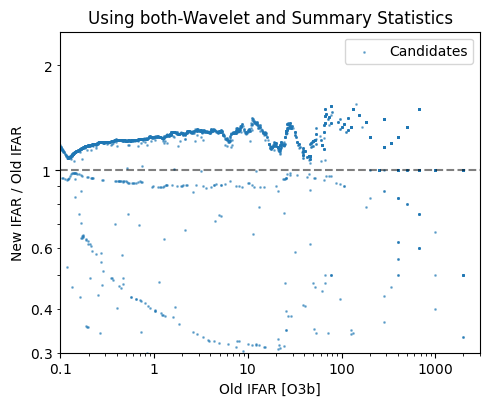

In [ ]:
# Plot IFAR improvement comparison: New vs. Old ranking
# Shows performance gains from learned wavelet + summary statistics approach
plt.figure(figsize=(6/1.2,5/1.2))
plt.scatter(ifar_inj_old, ifar_inj/ifar_inj_old, alpha=0.5, label='Candidates', color='C0', marker='o', s=1)
# plt.scatter(ifar_cand_old, ifar_cand/ifar_cand_old, alpha=0.5, label='Coincidence trigs', color='C1', marker='o')
plt.xlim(0.1, 3000)
plt.ylim(0.3, 2.5)
plt.axhline(y=1, color='black', linestyle='--', alpha=0.5)
plt.xscale('log'); plt.yscale('log')
plt.legend()
plt.xlabel(f'Old IFAR [{run}]')
plt.ylabel('New IFAR / Old IFAR')
plt.title(f'Using both-Wavelet and Summary Statistics')
plt.tight_layout()

plt.savefig(f'/home/apimpalkar/codes/plots/IFAR_comparison_BBH{ib}.pdf')